In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pulp import *

#### Datasets: Import and Preprocessing

In [ ]:
# Import
df = pd.read_excel('instance_2c.xlsx','RegionLevel')
matrix = df.to_numpy() #matrice
var2 = pd.read_excel('instance_2c.xlsx',sheet_name=0)
slr = var2['Value'].to_numpy()[0] #sea elevation
var3 = pd.read_excel('instance_2c.xlsx',sheet_name=1)
asset0 = var3.to_numpy()
assets = [(asset0[i][1]+1,asset0[i][2]+1) for i in range(len(asset0))]
start_nodes = []



#Add borders representing water sources

if matrix[1,1] < slr: 
    matrix[0,0] = 2
if matrix[len(matrix)-2,len(matrix)-2] < slr:
    matrix[len(matrix)-1,len(matrix)-1] = 2
if matrix[1,len(matrix)-2] < slr:
    matrix[0,len(matrix)-1] = 2
if matrix[len(matrix)-2,1] < slr:
    matrix[len(matrix)-1,0] = 2
for j in range(1,len(matrix)-1):
    if matrix[1,j] < slr and j != 1 and j!= len(matrix)-2 : 
        #matrix[0,j-1] = 2
        matrix[0,j] = 999
        #matrix[0,j+1] = 2

    if matrix[len(matrix)-2,j] < slr and j!=1:
        #matrix[len(matrix)-1,j-1] = 2
        matrix[len(matrix)-1,j] = 2
        #matrix[len(matrix)-1,j+1] = 2
for i in range(1,len(matrix)-1):
    if matrix[i,1] < slr and i!=len(matrix)-2 and i!=1:
        #matrix[i-1,0] = 2
        matrix[i,0] = 2
        #matrix[i+1,0] = 2
    if matrix[i,len(matrix)-2] < slr and i !=1 and i != len(matrix)-2:
        #matrix[i-1,len(matrix)-1] = 2
        matrix[i,len(matrix)-1] = 2
        #matrix[i+1,len(matrix)-1] = 2

#### Graph generation using NetworkX

In [ ]:
def generate_graph(matrix, slr):

    G = nx.Graph()

    pos = {}
    # Add nodes to the graph
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            if matrix[i][j] < slr :
                G.add_node((i,j))

    for i, j in G.nodes():
        if  i == 0 or j == 0 or i == len(matrix)-1 or j == len(matrix)-1:
            if i ==0 and j==0:
                G.add_edge((i,j),(i+1,j+1),cost=slr-matrix[i+1,i+1])
            elif i==len(matrix)-1 and j == len(matrix)-1:
                G.add_edge((i,j),(i-1,j-1),cost=slr-matrix[i-1,j-1])
            elif i ==0 and j == len(matrix)-1 : 
                G.add_edge((i,j),(i+1,j-1),cost=slr-matrix[i+1,j-1])
            elif i==len(matrix)-1 and j == 0:
                G.add_edge((i,j),(i-1,j+1),cost=slr-matrix[i-1,j+1])
            elif i==0:
                G.add_edge((i,j),(i+1,j),cost=slr-matrix[i+1,j])
            elif i==len(matrix)-1:
                G.add_edge((i,j),(i-1,j),cost=slr-matrix[i-1,j])
            elif j==0:
                G.add_edge((i,j),(i,j+1),cost=slr-matrix[i,j+1])
            elif j==len(matrix)-1:
                G.add_edge((i,j),(i,j-1),cost=slr-matrix[i,j-1])

            
        else:
            if i+1 < matrix.shape[0]-1 and matrix[i+1, j] < slr:
                G.add_edge((i, j), (i+1, j),cost=slr-min(matrix[i,j],matrix[i+1,j]))
            if j+1 < matrix.shape[1]-1 and matrix[i, j+1] < slr :
                G.add_edge((i, j), (i, j+1),cost=slr-min(matrix[i,j],matrix[i,j+1]))
            if i-1 >= 0 and matrix[i-1, j] < slr:
                G.add_edge((i, j), (i-1, j),cost=slr-min(matrix[i,j],matrix[i-1,j]))
            if j-1 >= 0 and matrix[i, j-1] < slr:
                G.add_edge((i, j), (i, j-1),cost=slr-min(matrix[i,j],matrix[i,j-1]))
            if i+1 < matrix.shape[0]-1 and j+1 < matrix.shape[1]-1 and matrix[i+1, j+1] < slr:
                G.add_edge((i, j), (i+1, j+1),cost=slr-min(matrix[i,j],matrix[i+1,j+1]))
            if i-1 >= 0 and j+1 < matrix.shape[1]-1 and matrix[i-1, j+1] < slr:
                G.add_edge((i, j), (i-1, j+1),cost=slr-min(matrix[i,j],matrix[i-1,j+1]))
            if i+1 < matrix.shape[0]-1 and j-1 >= 1 and matrix[i+1, j-1] < slr:
                G.add_edge((i, j), (i+1, j-1),cost=slr-min(matrix[i,j],matrix[i+1,j-1]))
            if i-1 >= 1 and j-1 >= 1 and matrix[i-1, j-1] < slr:
                G.add_edge((i, j), (i-1, j-1),cost=slr-min(matrix[i,j],matrix[i-1,j-1]))


    return G

#Graph:
G = generate_graph(matrix, slr)

#### Mixed Integer Programming (MIP)

In [9]:
# Trouver les nœuds de départ et d'arrivée
start_nodes = []
routes = []

for asset in assets:
    end_node = asset
    for node in G.nodes():
        if node[0] == 0 or node[0] == matrix.shape[0]-1 or node[1] == 0 or node[1] == matrix.shape[1]-1:
            start_nodes.append(node)
# Trouver les routes
    for start_node in start_nodes:
        #for path in nx.all_simple_paths(G, source=start_node, target=end_node):
        if nx.has_path(G,start_node,asset):
            for path in nx.all_simple_paths(G, source=start_node, target=end_node):
                routes.append(path)



In [10]:
#solveur:

# Step 1: Define the problem
prob = LpProblem("Example problem", LpMinimize)

# Step 2: Create decision variables using a loop
num_vars = len(G.edges.data())-1
x = []
c = []
D = []
L = list(G.edges.data())
for i in range(len(L)):
    H = set([L[i][0],L[i][1]])
    D.append(H)
    x.append(LpVariable(f"x{i}", lowBound=0, cat='binary'))
    c.append(L[i][2]['cost'])

    # Step 3: Add decision variables to the problem object
    #prob += lpSum(x)

# Step 4: Define the objective function
prob += lpSum([c[i]*x[i] for i in range(num_vars)])

In [11]:
# Step 5: Add constraints to the problem object
for r in routes:
    I=[]
    for i in range(len(r)-1) :
        I.append(D.index(set([r[i],r[i+1]])))
    prob += lpSum(x[i] for i in I) >= 1

In [12]:
# Step 6: Solve the problem
prob.solve()

1

In [13]:
# Step 7: Retrieve the results
barrieres=[]
edge_colors = {}
print("Optimal solution:")
s=0
for i in range(num_vars):
    if value(x[i]) == 1:
        barrieres.append(D[i])
        s+=1
    print(f"x{i} =", value(x[i]))

print('\033[1m' + "Optimal objective function value:", value(prob.objective))
print('\033[1m' + 'Nb barrieres est:', s)
print('\033[1m' + 'Les barrieres sont:', barrieres)

Optimal solution:
x0 = 0.0
x1 = 0.0
x2 = 0.0
x3 = 0.0
x4 = 0.0
x5 = 0.0
x6 = 0.0
x7 = 0.0
x8 = 0.0
x9 = 0.0
x10 = 0.0
x11 = 0.0
x12 = 0.0
x13 = 0.0
x14 = 0.0
x15 = 0.0
x16 = 0.0
x17 = 0.0
x18 = 0.0
x19 = 0.0
x20 = 0.0
x21 = 0.0
x22 = 0.0
x23 = 0.0
x24 = 0.0
x25 = 0.0
x26 = 0.0
x27 = 0.0
x28 = 0.0
x29 = 0.0
x30 = 0.0
x31 = 0.0
x32 = 0.0
x33 = 0.0
x34 = 0.0
x35 = 0.0
x36 = 0.0
x37 = 0.0
x38 = 0.0
x39 = 0.0
x40 = 0.0
x41 = 0.0
x42 = 0.0
x43 = 0.0
x44 = 0.0
x45 = 0.0
x46 = 0.0
x47 = 0.0
x48 = 0.0
x49 = 0.0
x50 = 0.0
x51 = 0.0
x52 = 0.0
x53 = 0.0
x54 = 0.0
x55 = 0.0
x56 = 1.0
x57 = 0.0
x58 = 0.0
x59 = 0.0
x60 = 0.0
x61 = 0.0
x62 = 0.0
x63 = 0.0
x64 = 0.0
x65 = 0.0
x66 = 0.0
x67 = 0.0
x68 = 1.0
x69 = 0.0
x70 = 0.0
x71 = 0.0
x72 = 0.0
x73 = 0.0
x74 = 0.0
x75 = 0.0
x76 = 0.0
x77 = 0.0
x78 = 0.0
x79 = 0.0
x80 = 0.0
x81 = 0.0
x82 = 0.0
x83 = 0.0
x84 = 0.0
x85 = 0.0
x86 = 0.0
x87 = 0.0
x88 = 0.0
x89 = 0.0
x90 = 0.0
x91 = 0.0
x92 = 0.0
x93 = 0.0
x94 = 0.0
x95 = 0.0
x96 = 0.0
x97 = 0.0
x98 = 0.0
x9

#### Visualization

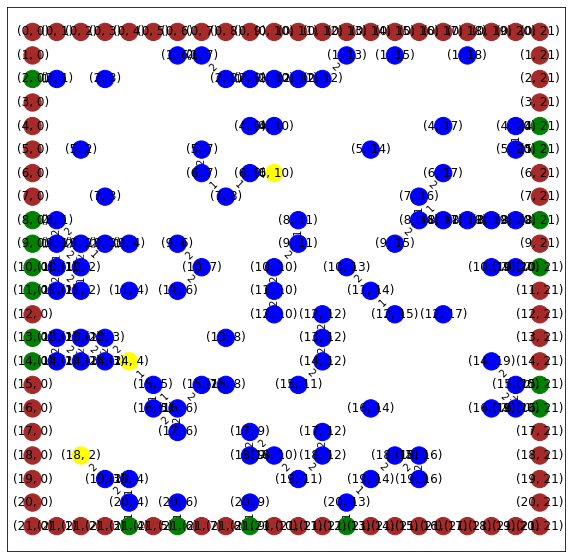

In [14]:
#pos
node_colors=[]
edge_colors=[]
R=[]
for i in range(len(barrieres)):
    R.append(tuple(barrieres[i]))

for i in range(len(matrix)):
    if matrix[i,0] >= slr: G.add_node((i,0))
    if matrix[0,i] >= slr: G.add_node((0,i))
    if matrix[len(matrix)-1,i] >= slr: G.add_node((len(matrix)-1,i))
    if matrix[i,len(matrix)-1] >= slr: G.add_node((i,len(matrix)-1))
for node in G.nodes():
    c=""
    if node in assets :
        c="yellow"
    elif node[0]== 0 or node[0]==len(matrix)-1 or node[1]==0 or node[1]==len(matrix)-1 :
        if matrix[node] < slr:
            c="green"
        else:
            c="brown"
    elif c!= "green" and c!="yellow" and c!="pink":
        c="blue"
    node_colors.append(c)
for edge in list(G.edges()):
    color=""
    if edge in R:
        color="red"
    else:
        if color !="red":
            color="black"
    edge_colors.append(color)


#pos
node_colors=[]
edge_colors=[]
R=[]
for i in range(len(barrieres)):
    R.append(tuple(barrieres[i]))

for i in range(len(matrix)):
    if matrix[i,0] >= slr: G.add_node((i,0))
    if matrix[0,i] >= slr: G.add_node((0,i))
    if matrix[len(matrix)-1,i] >= slr: G.add_node((len(matrix)-1,i))
    if matrix[i,len(matrix)-1] >= slr: G.add_node((i,len(matrix)-1))
for node in G.nodes():
    c=""
    if node in assets :
        c="yellow"
    elif node[0]== 0 or node[0]==len(matrix)-1 or node[1]==0 or node[1]==len(matrix)-1 :
        if matrix[node] < slr:
            c="green"
        else:
            c="brown"
    elif c!= "green" and c!="yellow" and c!="pink":
        c="blue"
    node_colors.append(c)
for edge in G.edges:
    if set(edge) in barrieres:
        edge_colors.append('red')
    else:
        edge_colors.append('black')
    

pos = {}
fig, ax = plt.subplots(figsize=(10, 10))
for k in G.nodes():
    pos[k]=(k[1],k[0])
nx.draw_networkx(G,pos=pos, with_labels=True,node_color=node_colors,edge_color=edge_colors)
labels = nx.get_edge_attributes(G,'cost')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.gca().invert_yaxis()
plt.show()